In [369]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [370]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian

from decode_fish.funcs.visualization import *
import ipyvolume as ipv

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [371]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training

Load base config

In [372]:
cfg = OmegaConf.load('config/train.yaml')

Make dataset specific changes

In [373]:
cfg.run_name ='N2_352_11'
cfg.data_path.image_path = base_path + '/datasets/CodFish/N2_352-1.tif'
cfg.data_path.psf_path = base_path + '/decode_fish/data/N2_352_psf.pkl'
cfg.ground_truth = None
cfg.microscope.multipl = 200
cfg.pointprocess.min_int = 0.3
cfg.microscope.psf_extent_zyx = [21,21,21]
cfg.autoencoder.lr = 5e-5
cfg.dataloader.bs = 2

cfg.supervised.num_iter = 12000
cfg.autoencoder.num_iter = 12000

cfg.evaluation.txt_path = None
cfg.evaluation.crop_sl = 's_[:,200:250,150:200,:]'
cfg.evaluation.px_size =  [100,100,100]

cfg.foci.n_foci_avg = 3.
cfg.foci.rad_range = [25,200]
cfg.foci.mode ='gaussian'

Store the config as an experiment

In [374]:
OmegaConf.save(cfg, f'config/experiment/{cfg.run_name}.yaml')

In [375]:
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)

Plot projections of the volume

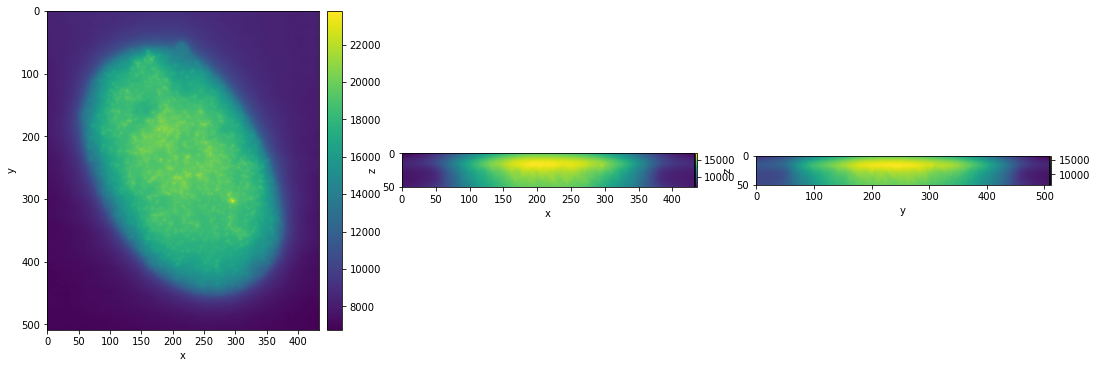

In [376]:
_ = plot_3d_projections(img_3d)

Plot a sample from our dataloader showing a slice from the input volume and from a simulated training volume

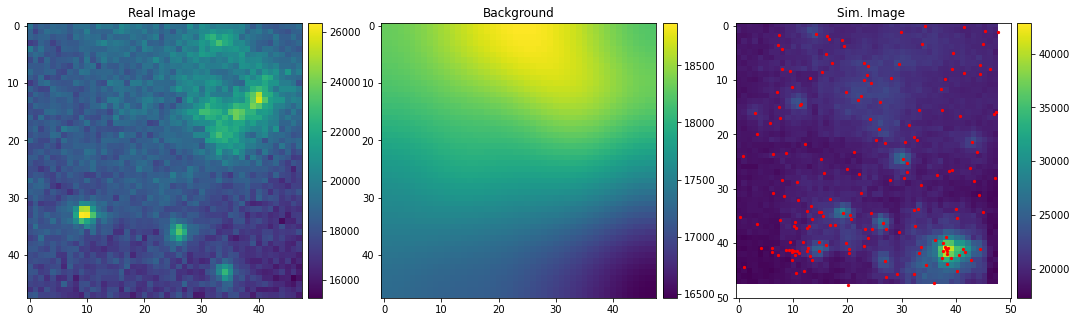

In [377]:
get_simulation_statistics(decode_dl, micro, int_threshold=10000)

Command to train a model on the gpu cluster

In [378]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ocodsub.log -e {home_dir}/logs/ecodesub.log {home_dir}/anaconda3/envs/decode2_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ocodsub.log -e /groups/turaga/home/speisera/logs/ecodesub.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=N2_352_11'

# Evaluation

In [387]:
cfg = OmegaConf.load(f'config/experiment/N2_352_10.yaml')
exp_dir = 'N2_9/'
cfg = OmegaConf.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/' + exp_dir + 'supervised.step_size:120000/train.yaml')
# cfg = OmegaConf.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/' + exp_dir + 'foci.n_foci_avg:3/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_3/autoencoder.lr:5e-05/train.yaml')

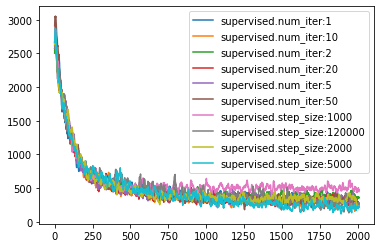

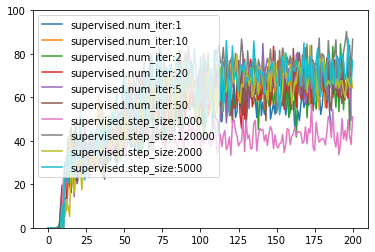

KeyError: 'Key AE Losses/RMSE(rec) was not found in Reservoir'

In [421]:
exps = sorted(glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/runs/' + str(Path(exp_dir))+'/*'))
fig = plot_tb_logs(exps, 'SL Losses/gmm_loss', 11)
plt.show()
fig = plot_tb_logs(exps, 'Sim. Metrics/eff_3d', 1)
plt.ylim(0,100)
plt.show()
fig = plot_tb_logs(exps, 'AE Losses/RMSE(rec)', 11)


In [397]:
# cfg = OmegaConf.load('config/train.yaml')
post_proc = hydra.utils.instantiate(cfg.post_proc)
post_proc

ISIPostProcess()

In [398]:
model = hydra.utils.instantiate(cfg.model)
model = load_model_state(model, cfg.output.save_dir, 'model.pkl')
bla, noise, micro = load_psf_noise_micro(cfg)
psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))

# psf, noise, micro = load_psf_noise_micro(cfg)
# psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))

# post_proc = hydra.utils.instantiate(cfg.post_proc)

<All keys matched successfully>

In [399]:
img_3d, decode_dl = get_dataloader(cfg)

Plot projections of the PSF before and after optimizing it during training

In [400]:
psf.psf_volume[0].sum()

tensor(113.0357, grad_fn=<SumBackward0>)

In [401]:
psf.psf_volume[0].sum()/torch.clamp_min(psf.psf_volume[0],0).sum()

tensor(0.9998, grad_fn=<DivBackward0>)

array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

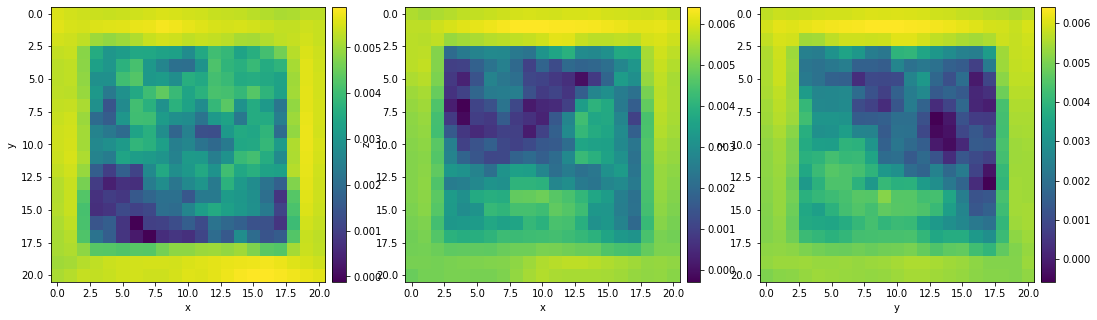

In [402]:
plot_3d_projections(torch.clamp_min(psf.psf_volume[0],0)-torch.clamp_min(bla.psf_volume[0],0),'mean')

array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

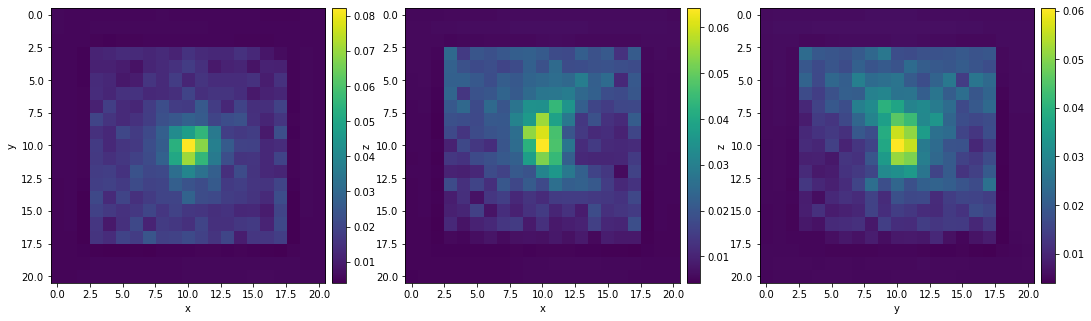

In [403]:
plot_3d_projections(torch.clamp_min(psf.psf_volume[0],0),'mean')

array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

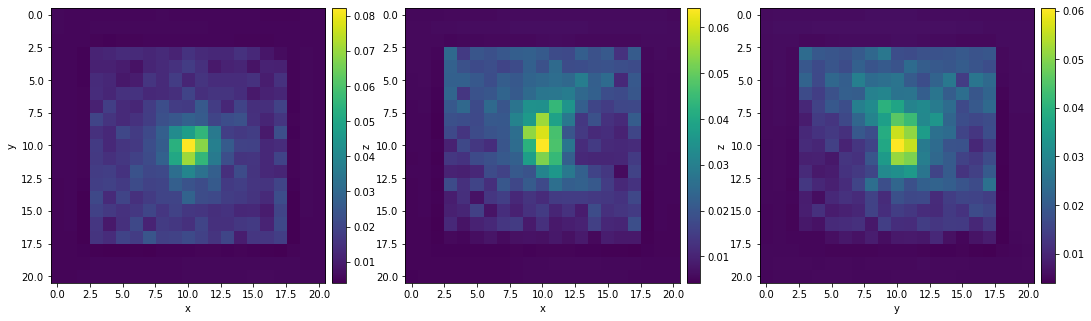

In [404]:
plot_3d_projections(torch.clamp_min(psf.psf_volume[0],0),'mean')

Sample random sub volumes and overlay them with predictions, also show the reconstructions from applying the microscope and psf model to those predictions

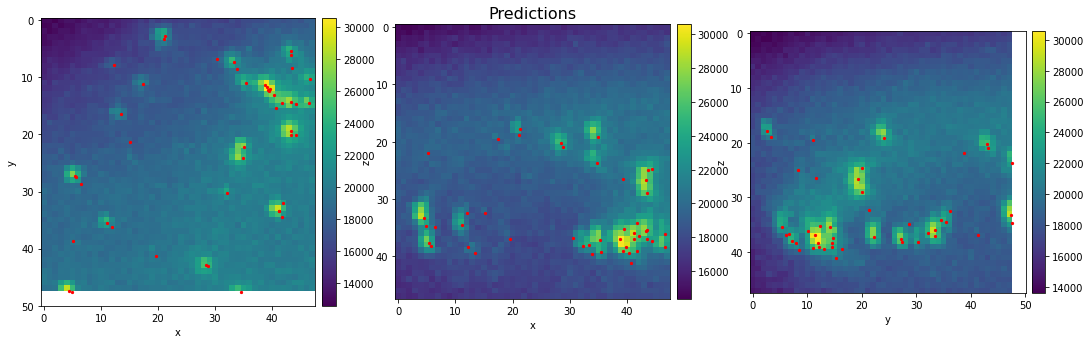

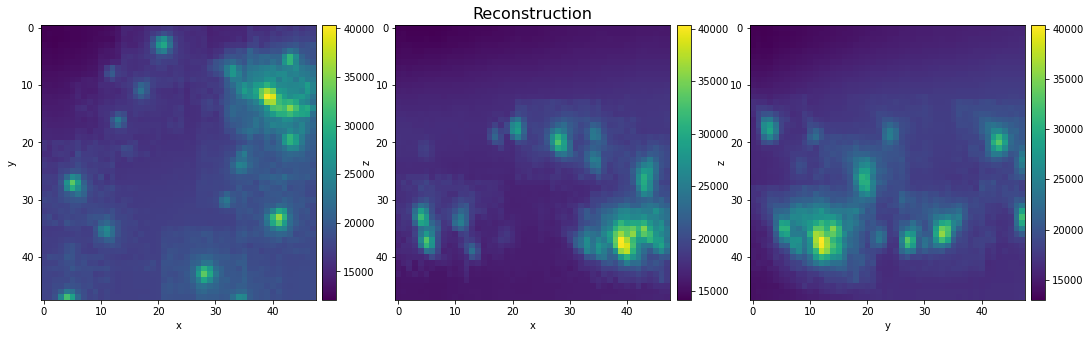

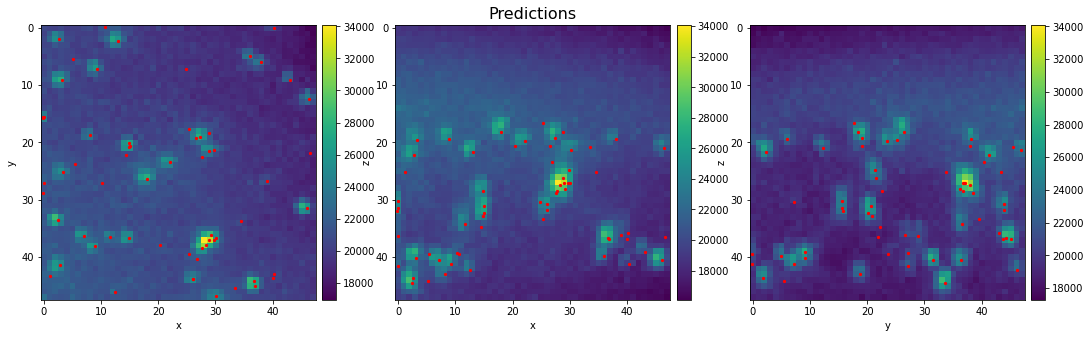

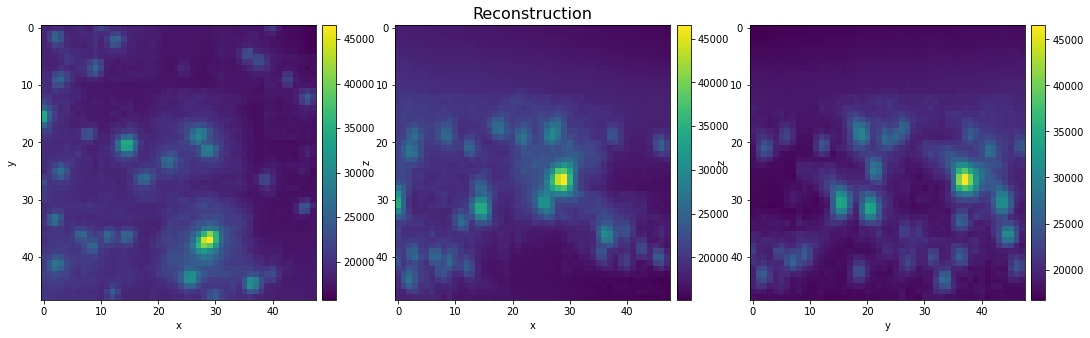

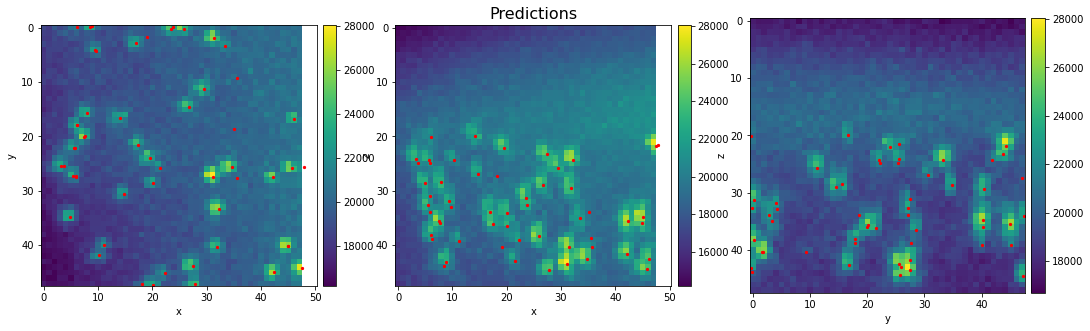

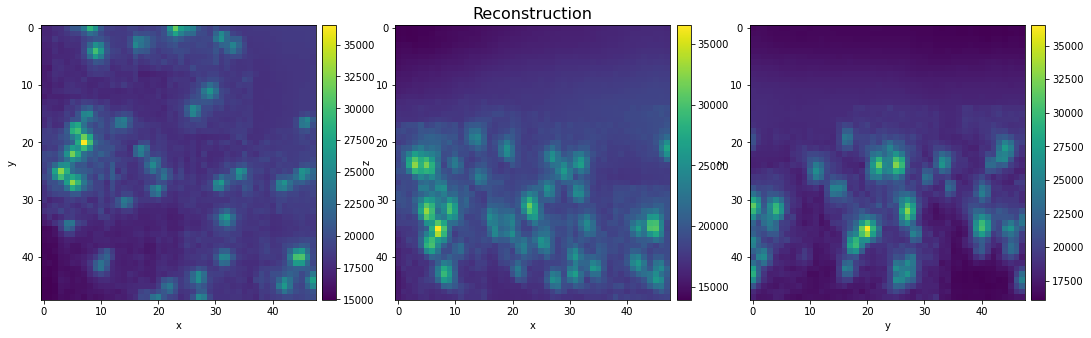

In [405]:
eval_random_crop(decode_dl, model, post_proc, micro, projection='max', samples=3)

Volume with Foci? Max projection of real volume, reconstruction, difference

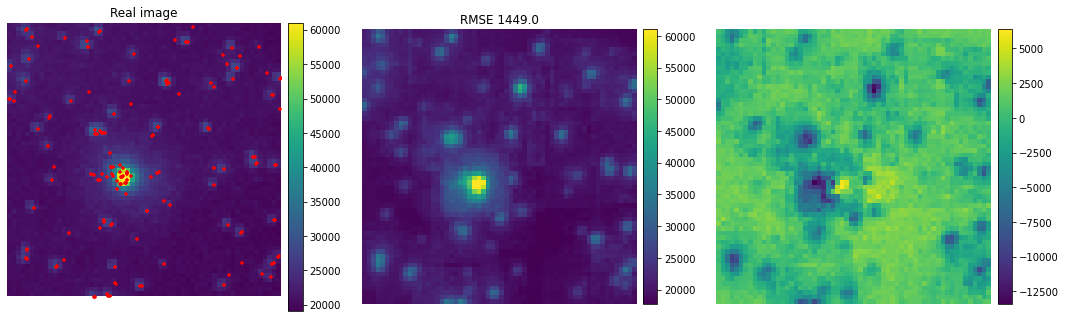

In [406]:
pred_df, gt_rec, _ = get_prediction(model,post_proc,img_3d[:,270:330,270:330], micro, return_rec=True, cuda=True)
_ = gt_plot(img_3d[:,270:330,270:330][None], pred_df, gt_df=None, px_size=[100,100,100], gt_rec=gt_rec[0])

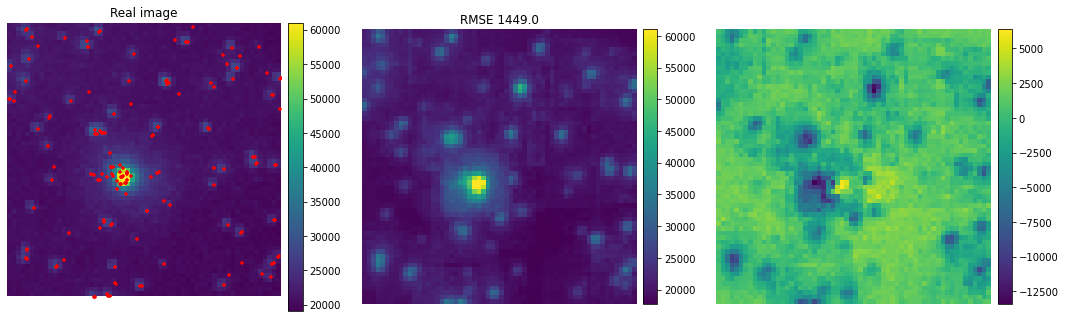

In [407]:
pred_df, gt_rec, _ = get_prediction(model,post_proc,img_3d[:,270:330,270:330], micro, return_rec=True, cuda=True)
_ = gt_plot(img_3d[:,270:330,270:330][None], pred_df, gt_df=None, px_size=[100,100,100], gt_rec=gt_rec[0])

In [408]:
cfg.prob_generator.high = 0.003
cfg.foci.n_foci_avg = 0
cfg.dataloader.bs=1
img_3d, decode_dl = get_dataloader(cfg)

In [409]:
projection='max', 
plot_gt=True, 
cuda=True, 
    
with torch.no_grad():

    x, local_rate, background = next(iter(decode_dl))

    sim_vars = PointProcessUniform(local_rate, min_int=decode_dl.min_int).sample()
    xsim = micro(*sim_vars)
    x = micro.noise(xsim, background).sample()

N true: 74
N pred: 74
P sum: 80.11181640625


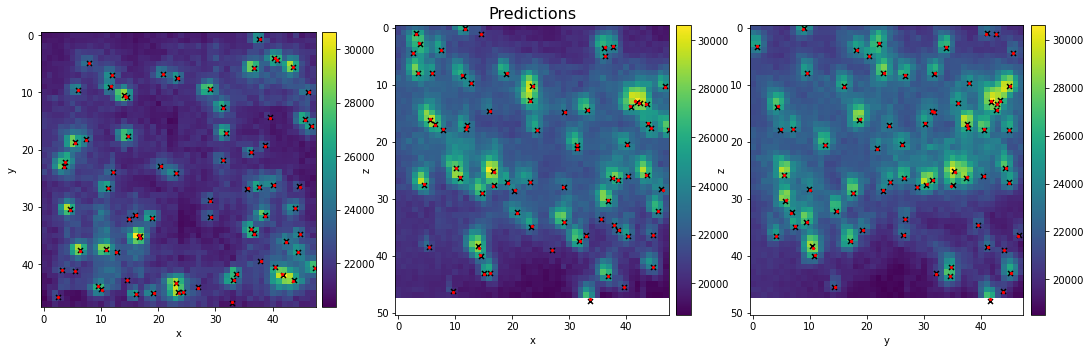

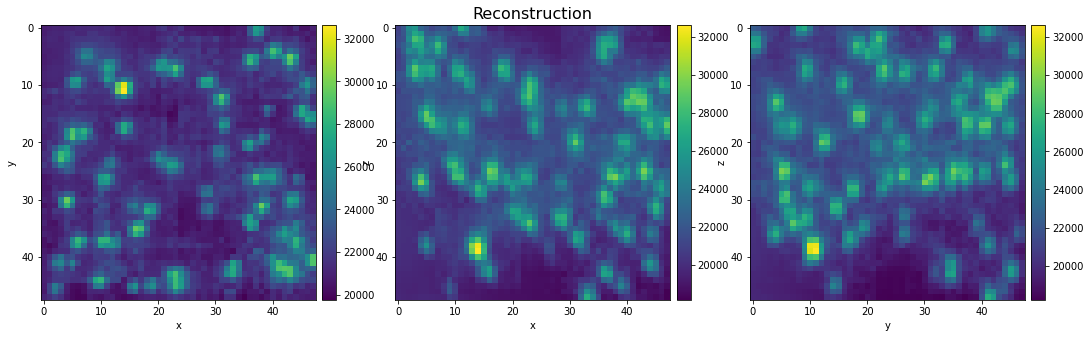

In [410]:
pred_df, rec, res_dict = get_prediction(model, post_proc, x[:1], micro=micro, cuda=True, return_rec=True)
pred_df = nm_to_px(pred_df, post_proc.px_size)
sim_df = nm_to_px(sample_to_df(*sim_vars[:-1]))
sim_df = sim_df[sim_df['frame_idx']==0]

xp = x[0,0].cpu().numpy()
recp = rec[0,0].cpu().numpy()

axes = plot_3d_projections(xp, projection=projection)

if plot_gt:
    axes[0].scatter(sim_df['x'],sim_df['y'], color='black', marker='x', s=25.)
    axes[1].scatter(sim_df['x'],sim_df['z'], color='black', marker='x', s=25.)
    axes[2].scatter(sim_df['y'],sim_df['z'], color='black', marker='x', s=25.)

axes[0].scatter(pred_df['x'],pred_df['y'], color='red', s=5.)
axes[1].scatter(pred_df['x'],pred_df['z'], color='red', s=5.)
axes[2].scatter(pred_df['y'],pred_df['z'], color='red', s=5.)

axes[1].set_title('Predictions', size=16)

axes = plot_3d_projections(recp, projection=projection)
axes[1].set_title('Reconstruction', size=16)

p_sum = torch.sigmoid(res_dict['logits']).sum().item()

print(f'N true: {len(sim_df)}')
print(f'N pred: {len(pred_df)}')
print(f'P sum: {p_sum}')
torch.save(res_dict, 'data/model_output_1.pt')
torch.save(sim_df, 'data/gt_1.pt')

In [411]:
samp_threshold = 0.1
mask_tresholds=[0.03,0.3]
px_size=[100,100,100]

def get_sim_perf(decode_dl, model, post_proc, micro, cuda=True, batches=10, print_res=True):

    gt_dfs = []
    pred_dfs = []
    rec_mae = []
    rec_rmse = []
    
    for _ in range(batches):
        x, local_rate, background = next(iter(decode_dl))
        sim_vars = PointProcessUniform(local_rate, min_int=decode_dl.min_int).sample()
        xsim = micro(*sim_vars)
        x = micro.noise(xsim, background).sample()
        pred_df, rec, res_dict = get_prediction(model, post_proc, x, micro=micro, cuda=True, return_rec=True)
        pred_dfs.append(pred_df)
        gt_dfs.append(sample_to_df(*sim_vars[:-1]))
        rec_mae.append(abs(x-rec).mean().item())
        rec_rmse.append(torch.sqrt(((x-rec)**2).mean()).item())

        
    gt_df = cat_emitter_dfs(gt_dfs)
    pred_df = cat_emitter_dfs(pred_dfs)
    perf_df, matches, _ = matching(gt_df, pred_df, tolerance=500, print_res=print_res)
    perf_df['mae'] = np.mean(rec_mae)
    perf_df['rmse'] = np.mean(rec_rmse)
    
    return perf_df

In [412]:
post_proc1 = SIPostProcess(m1_threshold=0.03, m2_threshold=0.3, samp_threshold=0.1, px_size=[100,100,100], diag=False)
post_proc2 = ISIPostProcess(m1_threshold=0.03, samp_threshold=0.3, px_size=[100,100,100], diag=True)

In [413]:
get_sim_perf(decode_dl, model, post_proc2, micro, print_res=False)

{'recall': 0.9960210880608636,
 'precision': 0.9881577647160836,
 'jaccard': 0.9842723501252032,
 'rmse_vol': 15.827309789584831,
 'rmse_x': 8.287071543894879,
 'rmse_y': 8.716359476434256,
 'rmse_z': 10.288501407641084,
 'eff_3d': 91.931572427064,
 'mae': 397.7185363769531,
 'rmse': 501.53403930664064}

In [414]:
get_sim_perf(decode_dl, model, post_proc1, micro, print_res=False)

{'recall': 0.9933509317352485,
 'precision': 0.8146127792134374,
 'jaccard': 0.8101950520184269,
 'rmse_vol': 16.14352575020786,
 'rmse_x': 7.853341780556324,
 'rmse_y': 10.592193983745641,
 'rmse_z': 9.31363927929873,
 'eff_3d': 79.37446876575581,
 'mae': 436.2128479003906,
 'rmse': 678.9222808837891}

In [54]:
get_sim_perf(decode_dl, model, post_proc, micro, print_res=False)

{'recall': 0.8955223546446882,
 'precision': 0.9844134132726244,
 'jaccard': 0.8830021425311152,
 'rmse_vol': 29.45798777648612,
 'rmse_x': 15.754069238080737,
 'rmse_y': 16.307543018464308,
 'rmse_z': 18.80548831054438,
 'eff_3d': 81.18967710317028,
 'mae': 238.69314270019532,
 'rmse': 405.921826171875}

In [54]:
p1_dicts = []
p2_dicts = []
p3_dicts = []

sweep = np.linspace(0.1,0.3,21)

for m in tqdm(sweep):
    post_proc1.m2_threshold = m
    p1_dicts.append(get_sim_perf(decode_dl, model, post_proc1, micro, print_res=False))
    
sweep = np.linspace(0.01,0.07,11)

for m in tqdm(sweep):
    post_proc2.m1_threshold = m
    p2_dicts.append(get_sim_perf(decode_dl, model, post_proc2, micro, print_res=False))
    
sweep = np.linspace(0.1,0.3,21)

for m in tqdm(sweep):
    post_proc2.samp_threshold = m
    p3_dicts.append(get_sim_perf(decode_dl, model, post_proc2, micro, print_res=False))

 19%|█▉        | 4/21 [00:13<00:57,  3.39s/it]


KeyboardInterrupt: 

In [ ]:
# x,_,_ = next(iter(decode_dl))

In [ ]:
p3_dicts[0]

In [ ]:
metrics = ['jaccard','eff_3d','mae','rmse']
for m in metrics:
    y = [d[m] for d in p1_dicts]
    plt.plot(y)
    y = [d[m] for d in p2_dicts]
    plt.plot(y)
    y = [d[m] for d in p3_dicts]
    plt.plot(y)
    plt.show()

In [ ]:
with torch.no_grad():
    model.cpu()
    res = model(img_3d[None,None])
#     res = model(x.cpu())
    pred_df = model_output_to_df(res, 0.1, px_size=[100,100,100])
    free_mem()

Inferred intensities

In [ ]:
_ = plt.hist(pred_df['int'])
print(len(pred_df))

In [ ]:
def scatter3d_df(df, shape, px_size=[100,100,100], color='red', size=1):
    ipv.scatter(df['x']/px_size[0] - 1/2*shape[2], 
                df['y']/px_size[1] - 1/2*shape[1], 
                df['z']/px_size[2] - 1/2*shape[0], size=size, marker='sphere', color=color)

3D rendering

In [ ]:
vol = img_3d.numpy()

extent = [[-s/2,s/2] for s in vol.shape]
extent = [extent[i] for i in [2,1,0]]

ipv.figure()
ipv.pylab.volshow(vol, level=[.2,0.25,.1], opacity=[0.04,0.2,0.01], extent=extent)
scatter3d_df(pred_df, vol.shape, [100.,100.,300.], 'black', size=0.5)
ipv.xyzlim(max(vol.shape)/2)
ipv.view(90, 40)
ipv.show()